## Importing the goodies

In [18]:
import numpy as np
import torch
import torch.nn as nn      
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from PIL import Image
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
import tqdm
from numpy import moveaxis
import scipy.ndimage
from IPython.display import clear_output
import time
import pyautogui
from Xlib import display
from mss.linux import MSS as mss
import mss.tools

## Loading up the trained model

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
hunter.load_state_dict(torch.load("hunter.pt"))
hunter.eval()

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)

## Generating a class activation heatmap from an image using `generate_heatmap()`

* `input_tensor` = 4D tensor which has been made from the image, be mindful of `np.moveaxis()` if you're working with RGB images 
* `model` = specifies the model through wich we have to pass the tensor for a result 
* `kernel size = x` = specifies the 2D size of a subsample with size `(x,x)`
* `stride` = specifies the size of the step take by the filter in each iterations,
> * a smaller stride means more samples to be passed through the model,  hence taking up more computing power 
> * larger stride size gives faster but less accurate results in some cases, try finding a good combination of `stride` and `kernel size`
* `thresh_prob` = gives minimum probability for which that part of the image would get highlighted, a lower threshold probability means a noisier heatmap
* `label` = specifies the category label (a certain animal in our case) to look for in the image

In [4]:
def generate_heatmap(input_tensor, model, kernel_size, stride, thresh_prob, label):
    image = input_tensor
    width, height = image.shape[-2], image.shape[-1]
    output_height = int(np.ceil((height-kernel_size)/stride))
    output_width = int(np.ceil((width-kernel_size)/stride))
    heatmap = torch.zeros((output_width, output_height))
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            tensor_slice = input_image[:, :, w_start:w_end, h_start:h_end].squeeze(0)
            
            if 0 in tensor_slice.size():
                continue
        
            sweet_slice = np.moveaxis(tensor_slice.numpy(), 0, 2)
            sweet_slice = cv2.resize(sweet_slice, (25,25))
            sweet_tensor =  torch.from_numpy(np.moveaxis(sweet_slice, 2,0)).unsqueeze(0)
            output = model(sweet_tensor).flatten()
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                heatmap[w,h] = output*200  # mult
            else:
                heatmap[w,h] =  0.5 
                
    return heatmap.detach().numpy()

def detect_animal_heatmap(model, image_path, kernel_size, stride, label, threshold_prob):
    
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im2 = cv2.resize(im, (int(im.shape[1]/3), int(im.shape[0]/3)))
    plt.imshow(im2)
    plt.show()
   
    im2 = moveaxis(im2, 2, 0)

    input_tensor = torch.from_numpy(im2).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    heatmap = generate_heatmap(input_tensor, model, kernel_size, stride, threshold_prob, label)
    print(heatmap.shape)
    heat_shape = im.shape[:-1][::-1]
    heatmap = cv2.resize(heatmap,heat_shape )
    heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma = [16,16]) ## smoothen 2d image
    plt.set_cmap("jet_r")
    plt.imshow(heatmap)
    plt.show()
    plt.imsave("heatmap.png", heatmap)
    fin = cv2.addWeighted(cv2.imread(image_path), 0.6,cv2.imread("heatmap.png"),0.5, 0)
    f , axarr = plt.subplots(1,3)
    axarr[0].imshow(im, cmap = "gray")
    axarr[1].imshow(heatmap)
    axarr[2].imshow(fin)
    return fin

## Visualising the heatmap on a sample image

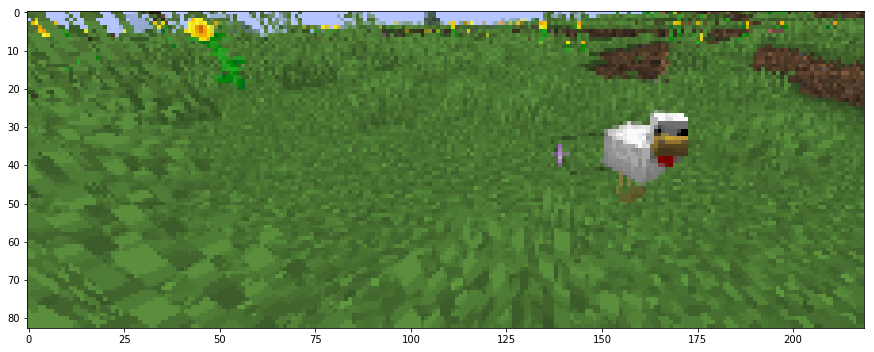

(11, 38)


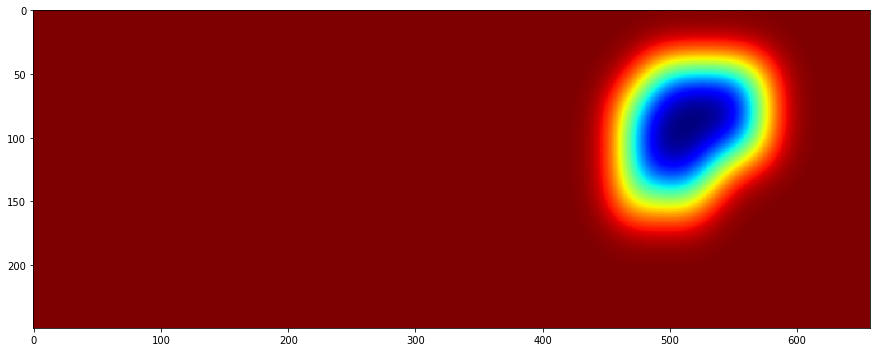

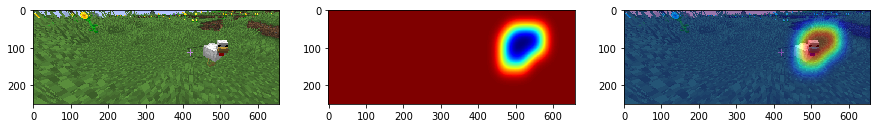

In [5]:
rcParams['figure.figsize'] = 15, 8
foo = detect_animal_heatmap(hunter, "barbecue_boi.png", 30, 5, 0, 0.99)

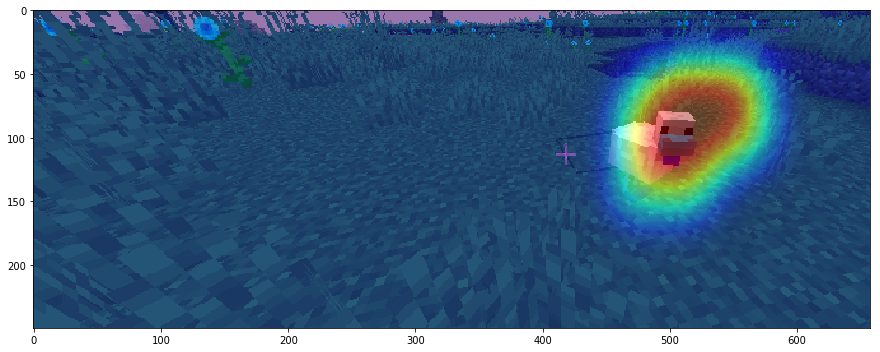

In [6]:
plt.imshow(foo)

## Start building the pipeline for detecting from a live video feed of the game
* in my case, MSS worked faster than the oter screen capture libraries
* `screen_cap()`returns a numpy array of the image with three channels R,G and B

In [7]:
def screen_cap(top = 0, left = 0, width = 650, height = 480):
    mon = {"top": top, "left": left, "width": width, "height": height}
    sct = mss.mss()
    img = np.array(sct.grab(mon))[...,:3]
    
    sct.close()
    return img

## A faster version of `generate_heatmap()` built on numpy 
* This one is made to handle RGB images returned by `screen_cap()`
* returns a co-ordinate as `[x, y]` wich specifies the location of the animal of a certain label

In [8]:
def return_target_numpy(input_np_arr, model, kernel_size, stride, thresh_prob, label):
    image = input_np_arr
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    width, height = image.shape[1], image.shape[0]
    circles = []
    move = False
    image_ret = image.copy()
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            
            np_slice = image[h_start:h_end, w_start:w_end, :]

            if 0 in np_slice.shape:
                continue
            np_slice = cv2.resize(np_slice, (25,25))   
            image_moveaxis =  np.moveaxis(np_slice, 2, 0)    
        
            sweet_tensor =  torch.from_numpy(image_moveaxis).unsqueeze(0).float()
            output = model(sweet_tensor).flatten()
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                
                circle_center = [int((w_end+w_start)/2), int((h_end+h_start)/2)]
                circles.append(circle_center)
            else:
                pass
    target = np.array([])
    if len(circles) != 0:
        move = True
        target = np.mean(np.array(circles), axis = 0).astype(np.uint8)
    return target, move

## Some other utils required for automation of the mouse

* `normalise targets()` transforms the co-ordinates of the target from the smaller image  to the larger original image
* `move_mouse_co_ord(x, y, time )`  moves the mouse to co-ordinates (x,y) on the screen and takes `time` time

In [10]:
def shoot_arrow():
    pyautogui.click(button="right")
    
def reload_arrow(time_taken):
    pyautogui.mouseDown(button = "right")
    time.sleep(time_taken)
    pyautogui.mouseUp(button = "right")

    
def strike_with_sword():
    pyautogui.click(button="left")


def normalise_targets(target, actual_image_size, small_image_size):
    
    new_x = int((target[0]/small_image_size[0])*actual_image_size[0])
    new_y = int((target[1]/small_image_size[1])*actual_image_size[1])    
    return [new_x, new_y]
    

def move_mouse_co_ord_x(x_val , time = 0.001):
    y_val = find_mouse(y = True)
    pyautogui.moveTo(x_val,y_val, duration= time )
    
def move_mouse_co_ord(x_val, y_val , time = 0.001):
    pyautogui.moveTo(x_val,y_val, duration= time )
    
    
def find_mouse(x = False , y = False):
    
    data = display.Display().screen().root.query_pointer()._data
    res = [data["root_x"], data["root_y"]]
    if x == True and y == True:
        return res
    elif x == True and y == False:
        return res[0]
    else:
        return res[1]

## The main loop

* the game window is captured and then the image is resized to 1/36th of it's size because we don't need the full size image, and using the full just makes the whole thing slower

* `center` is the co-ordinate of the crosshair of the player 

* `top_offset` is the thickness of the title bar(s) above the game screen, keep it at a higher value if you want to crop out the sky

* the chicken in the frame was circled for debugging but I didn't remove it later on because it looked cool



In [17]:
#  some time to breathe and pray that it doesn't embarass me by tracking sunflowers instead of chickens
time.sleep(3)  

while True:
    
    top_offset = 150
    
    center = (460, 180 )  # crosshairs on the screen
    start = time.time()
    frame = screen_cap(top= top_offset, height = 550 - top_offset, width = 800)
    
    #resize into a smaller image size 
    smaller_frame = cv2.resize(frame, (int(frame.shape[1]/6), int(frame.shape[0]/6)))
    target, move = return_target_numpy(smaller_frame ,hunter, 20, 12, 0.9, 0)
    
    #move mouse only when you see a chicken
    if move == True:
        print("found chicken at = ", target)
        target = normalise_targets(target, frame.shape[:-1], smaller_frame.shape[:-1])
        
        # drawing circles and lines because why not, slower but cooler looking pipeline
        frame = cv2.circle(frame, tuple(target), radius = 50, color = (0, 100, 255) , thickness = 2)
        frame = cv2.line(frame, center, tuple(target), color = (0,0,255), thickness = 5)
        
        try:
            # move mouse to a certain pos
            move_mouse_co_ord(x_val = target[0] , y_val = target[1] + top_offset, time = 0.0001)
            strike_with_sword()
        except:
            #panic mode basically
            break
            cv2.destroyAllWindows() 

    # weird flex by showing the live feed with circles and lines       
    cv2.imshow("hunter_fpv",frame)
    
    #press q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows() 
        break
      
    # metrics
    time_taken = time.time() - start
    clear_output(wait = True)

    print(int(1/time_taken), " FPS")


3  FPS
found chicken at =  [71 18]


In [19]:
cv2.destroyAllWindows() 